In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('..')
from chessvision.aruco import *
from chessvision.label import *
from chessvision.game import *
from chessvision.trainer import *

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [7]:
Storage.dir = "../games"
train_games = [
#     Game("Adams", 0),
    Game("Adams", 1),
    Game("Adams", 2),
    Game("Adams", 3),
]

test_games = [
    Game("Bird", 2)
]

In [8]:
len(test_games[0])

93

In [9]:
train_dir = save_games(train_games, label_fn=label, labels=PIECE_LABELS)
test_dir = save_games(test_games, label_fn=label, labels=PIECE_LABELS)
train_dir, test_dir, os.path.basename(train_dir)

('/tmp/chess-vision-ja0ahy7u',
 '/tmp/chess-vision-53sf6wc8',
 'chess-vision-ja0ahy7u')

In [123]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

SIZE = 68
data_transform = transforms.Compose([
    transforms.Resize(SIZE),
#     transforms.Grayscale(),
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=.75, hue=0.1),
    transforms.RandomCrop((int(SIZE*.9), int(SIZE*.9))),
    # transforms.RandomAffine(180),
    transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225])
])


chess_datasets = {'train': ChessFolder(root=train_dir, transform=data_transform),
                  'val'  : ChessFolder(root=test_dir, transform=data_transform)}

dataloaders = {'train': DataLoader(chess_datasets['train'], shuffle=True, batch_size=4, num_workers=4),
               'val': DataLoader(chess_datasets['val'], batch_size=50, num_workers=4)}

dataset_sizes = {x: len(chess_datasets[x]) for x in ['train', 'val']}
labels_dict = {hash(label): label for label in PIECE_LABELS}

cuda:0


In [124]:
dataset_sizes

{'train': 252, 'val': 93}

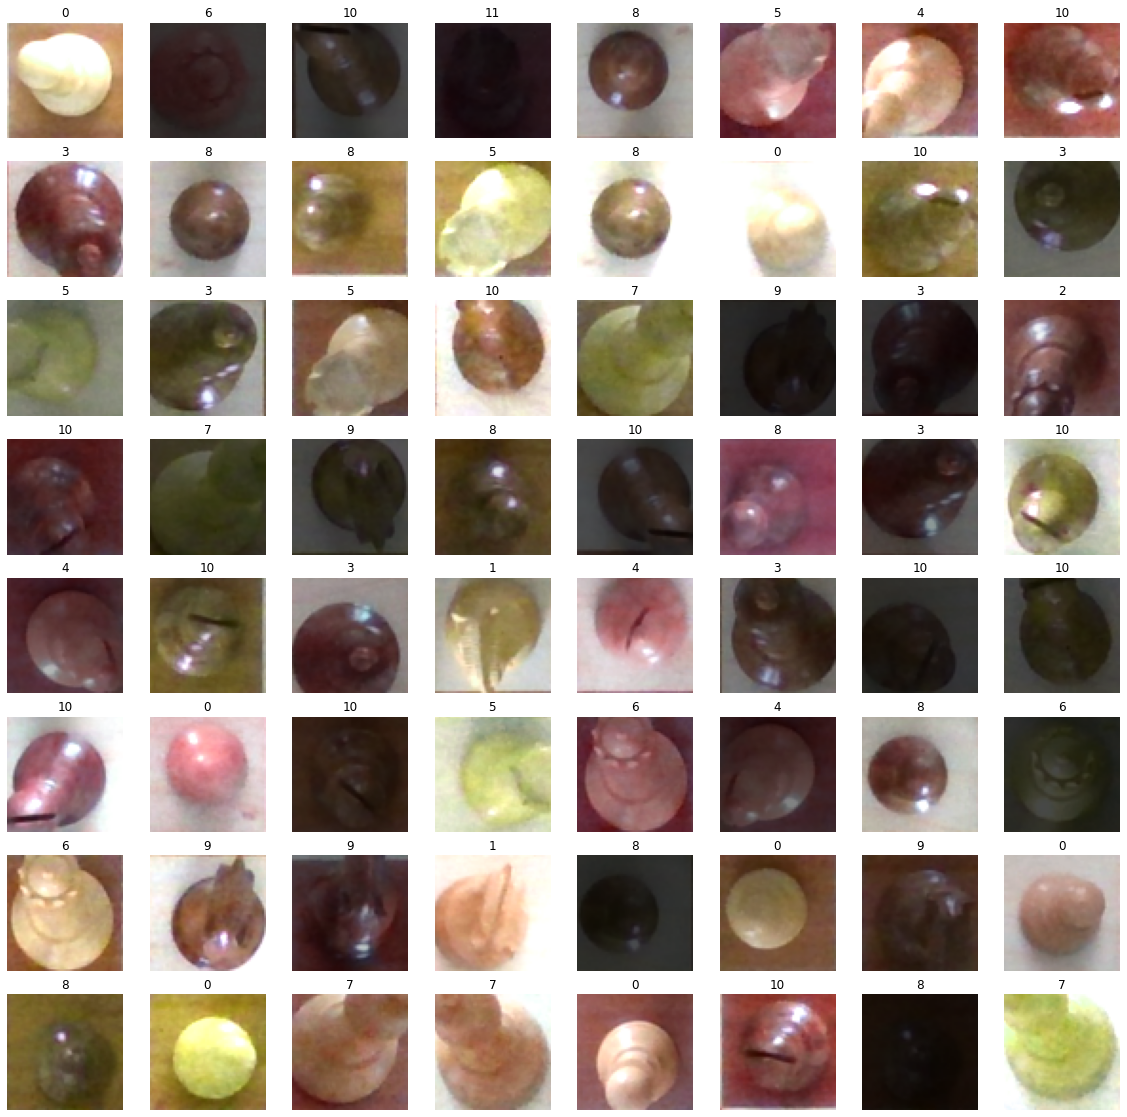

In [125]:
figure = plt.figure(figsize=(20, 20))
cols, rows = 8, 8
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset_sizes['val'], size=(1,)).item()
    img, label = chess_datasets['val'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.show()